In [40]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)

import shap

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings(action="ignore")

# Feature Engineering and Pre-Processing

In [41]:
import logging
from datetime import datetime

# Configure logging
logging.basicConfig(
    filename="model_predictions.log",  # Log file name
    level=logging.INFO,  # Logging level
    format="%(asctime)s - %(levelname)s - %(message)s",  # Log format
)

In [42]:
# categorical features / labels for high and low values
cat_coder = {
    "MCH": {
        "low": 27,
        "high": 33,
    },
    "MCHC": {
        "low": 32,
        "high": 36,
    },
    "MCV": {
        "low": 80,
        "high": 100,
    },
}


def mch_coder(x):
    if x < cat_coder["MCH"]["low"]:
        return "low"
    elif x > cat_coder["MCH"]["high"]:
        return "high"
    else:
        return "normal"


def mchc_coder(x):
    if x < cat_coder["MCHC"]["low"]:
        return "low"
    elif x > cat_coder["MCHC"]["high"]:
        return "high"
    else:
        return "normal"


def mcv_coder(x):
    if x < cat_coder["MCV"]["low"]:
        return "low"
    elif x > cat_coder["MCV"]["high"]:
        return "high"
    else:
        return "normal"


def hematocrit_coder(x, sex):
    if sex == "male":
        if x < 39:
            return "low"
        elif x > 50:
            return "high"
        else:
            return "normal"
    else:
        if x < 35:
            return "low"
        elif x > 47:
            return "high"
        else:
            return "normal"

In [43]:
# from sklearn.preprocessing import OneHotEncoder


def preprocessing(df):
    df = df.copy()
    #     Binary Encoding of gender
    df["SEX"] = df["SEX"].replace({"F": 0, "M": 1})

    return df


def split_data(df):
    # Splitting DF into X and y
    y = df["SOURCE"]
    X = df.drop("SOURCE", axis=1)

    X_train, x_test, y_train, y_test = train_test_split(
        X, y, train_size=0.7, shuffle=True, random_state=1
    )

    #    Scaling through Standard Scaler
    sc = StandardScaler()
    sc.fit(X_train)

    X_train = pd.DataFrame(
        sc.transform(X_train), columns=X_train.columns, index=X_train.index
    )
    x_test = pd.DataFrame(
        sc.transform(x_test), columns=x_test.columns, index=x_test.index
    )

    return X_train, x_test, y_train, y_test

In [44]:
df = pd.read_csv("../data/data-ori.csv")

df = preprocessing(df)

df.head()

HAEMATOCRIT  HAEMOGLOBINS  ERYTHROCYTE  LEUCOCYTE  THROMBOCYTE   MCH  MCHC  \
0         35.1          11.8         4.65        6.3          310  25.4  33.6   
1         43.5          14.8         5.39       12.7          334  27.5  34.0   
2         33.5          11.3         4.74       13.2          305  23.8  33.7   
3         39.1          13.7         4.98       10.5          366  27.5  35.0   
4         30.9           9.9         4.23       22.1          333  23.4  32.0   

    MCV  AGE  SEX SOURCE  
0  75.5    1    0    out  
1  80.7    1    0    out  
2  70.7    1    0    out  
3  78.5    1    0    out  
4  73.0    1    1    out

In [45]:
X_train, x_test, y_train, y_test = split_data(df)

# First Approach

In [46]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Neural Network": MLPClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
}

for k, v in models.items():
    v.fit(X_train, y_train)
    print(k + " Trained !")

Logistic Regression Trained !
Decision Tree Trained !
Neural Network Trained !
Random Forest Trained !
Gradient Boosting Trained !


In [47]:
for k, v in models.items():
    y_pred = v.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    print(k + " Accuracy : {:.2f}%".format(acc * 100))
    logging.info(f"Model: {k}, Accuracy: {acc}")

Logistic Regression Accuracy : 71.22%
Decision Tree Accuracy : 66.39%
Neural Network Accuracy : 75.08%
Random Forest Accuracy : 73.87%
Gradient Boosting Accuracy : 73.64%


In [48]:
for k, v in models.items():
    y_pred = v.predict(x_test)
    f1 = f1_score(y_test, y_pred, pos_label="in")
    print(k + " F1 score : {:.5f}".format(f1))
    logging.info(f"Model: {k}, F1 Score: {f1}")

Logistic Regression F1 score : 0.59768
Decision Tree F1 score : 0.58758
Neural Network F1 score : 0.68330
Random Forest F1 score : 0.66145
Gradient Boosting F1 score : 0.64783


In [49]:
import joblib

for k, model in models.items():
    # Save model
    joblib.dump(model, f"base/{k}.joblib")

In [51]:
y_pred

array(['in', 'out', 'out', ..., 'out', 'out', 'out'], dtype=object)

[[283 247]
 [134 660]]


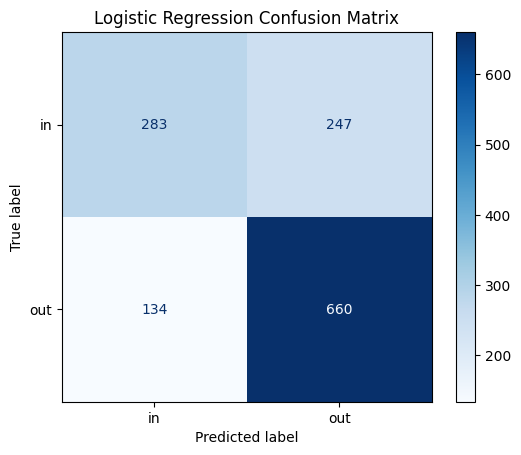

[[317 213]
 [232 562]]


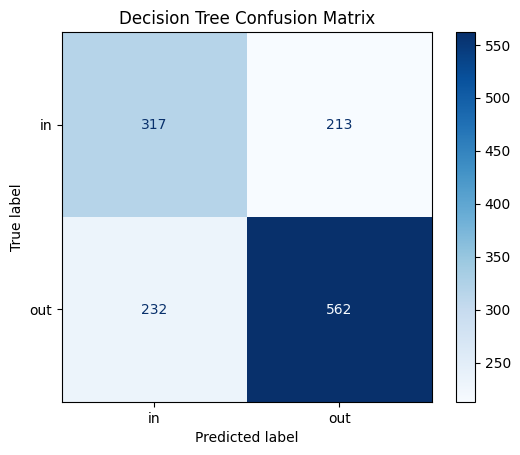

[[356 174]
 [156 638]]


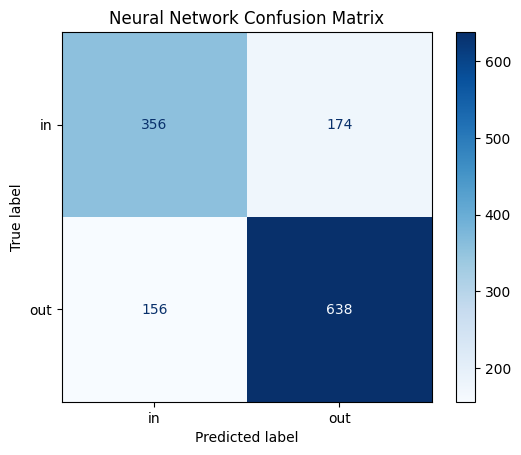

[[338 192]
 [154 640]]


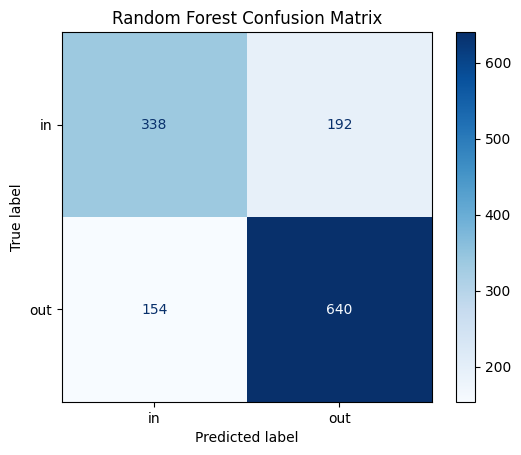

[[321 209]
 [140 654]]


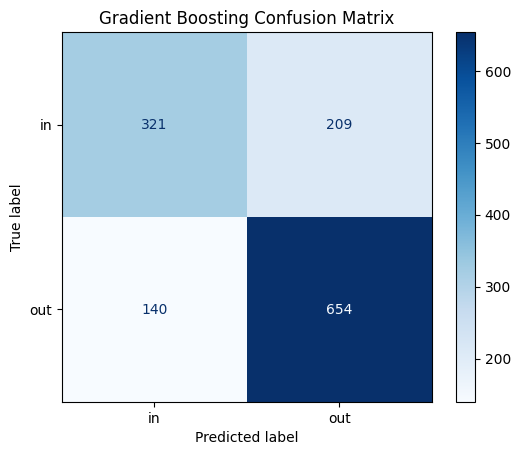

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# confusion matrix
for k, v in models.items():
    y_pred = v.predict(x_test)
    cm = confusion_matrix(y_test, y_pred, labels=["in", "out"])
    # print(cm)  # Print the raw matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["in", "out"])
    disp.plot(cmap="Blues")
    plt.title(k + " Confusion Matrix")
    plt.show()
# print(k + " Confusion Matrix")
# print(confusion_matrix(y_test, y_pred))

Looks like the best base model is the Neural Network. 

Average treatment probability is 0.4003


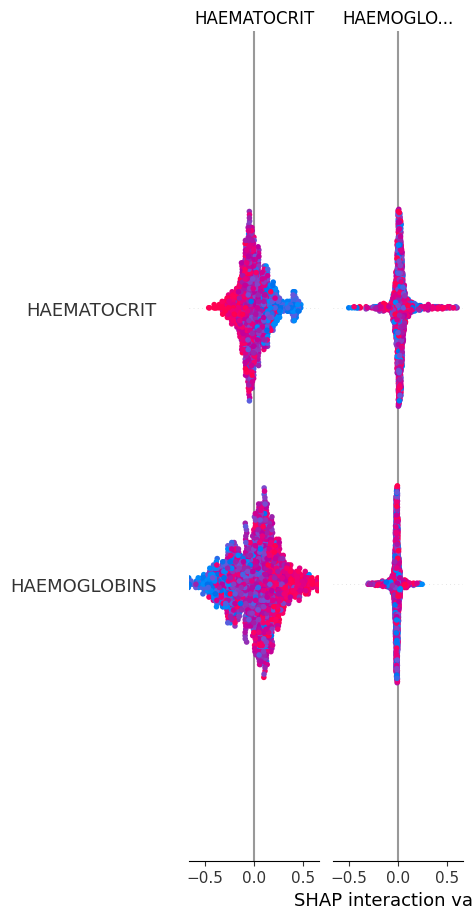

In [60]:
shap.initjs()

ex = shap.TreeExplainer(models["Decision Tree"])

print(
    f'Average treatment probability is {round(np.mean((y_test == "in").astype(int)),4)}'
)

shap_values = ex.shap_values(x_test)
shap.summary_plot(shap_values, x_test, max_display=30)

Average treatment probability is 0.4003


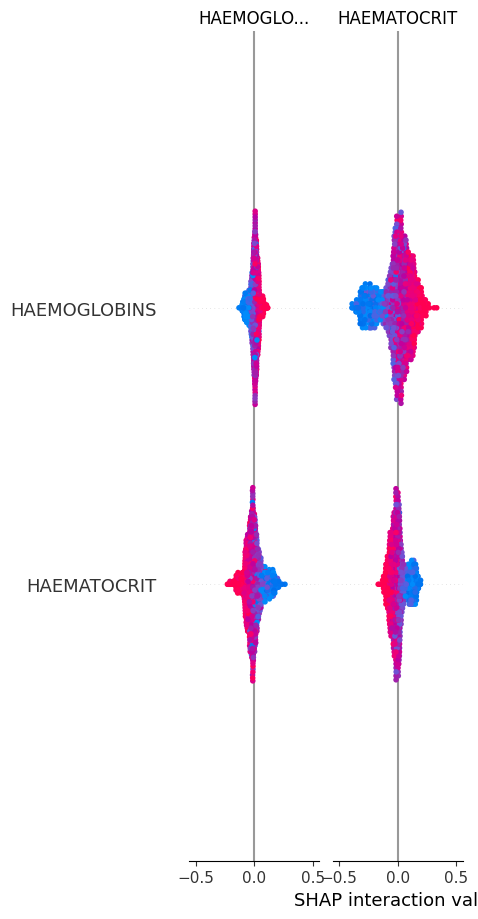

In [61]:
shap.initjs()

ex = shap.TreeExplainer(models["Random Forest"])

print(
    f'Average treatment probability is {round(np.mean((y_test == "in").astype(int)),4)}'
)

shap_values = ex.shap_values(x_test)
shap.summary_plot(shap_values, x_test, max_display=30)

# Second Approach

In [105]:
# initialize data
df = pd.read_csv("../data/data-ori.csv")

main_label = "SOURCE"

df["SEX"] = df["SEX"].replace({"F": 0, "M": 1})

df[main_label] = (df[main_label] == "in").astype(int)

y = df[main_label].values.reshape(
    -1,
)

X = df.drop([main_label], axis=1)

cat_cols = df.drop([main_label], axis=1).select_dtypes(include=["object"]).columns
cat_cols_idx = [list(X.columns).index(c) for c in cat_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2206, 10), (2206, 10), (2206,), (2206,))

In [106]:
from catboost import Pool, CatBoostClassifier

# initialize Pool
train_pool = Pool(X_train, y_train, cat_features=cat_cols_idx)
test_pool = Pool(X_test, y_test, cat_features=cat_cols_idx)

# specify the training parameters
model = CatBoostClassifier(
    iterations=1000,
    depth=5,
    border_count=23,
    l2_leaf_reg=0.3,
    learning_rate=3e-3,
    verbose=0,
)

# train the model
model.fit(train_pool)

# make the prediction using the resulting model
y_train_pred = model.predict_proba(train_pool)[:, 1]
y_test_pred = model.predict_proba(test_pool)[:, 1]

roc_auc_train = roc_auc_score(y_train, y_train_pred)
roc_auc_test = roc_auc_score(y_test, y_test_pred)

print(
    f"ROC AUC score for train {round(roc_auc_train,4)}, and for test {round(roc_auc_test,4)}"
)

ROC AUC score for train 0.8269, and for test 0.8107


In [107]:
# # calculating the baseline ROC AUC score assuming the same probability from training labels to test
# roc_auc_baseline = roc_auc_score(y_test, [np.mean(y_train)] * len(y_test))
# print(roc_auc_baseline)

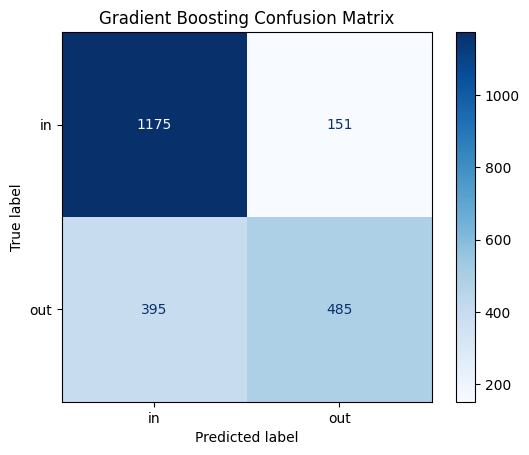

In [108]:
# Get the confusion matrix
cm = confusion_matrix(y_test, (y_test_pred > 0.5))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Plot the confusion matrix
# class_names = ["out", "in"]  # positive class should come the last
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["in", "out"])
disp.plot(cmap="Blues")
plt.title(k + " Confusion Matrix")
plt.show()

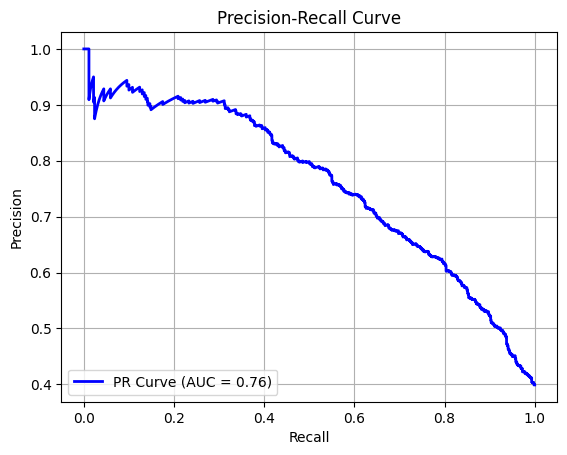

PR-AUC Score: 0.76
Average Precision Score: 0.76


In [109]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_test_pred)

# Compute PR-AUC
pr_auc = auc(recall, precision)
avg_precision = average_precision_score(y_test, y_test_pred)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color="blue", lw=2, label=f"PR Curve (AUC = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid()
plt.show()

print(f"PR-AUC Score: {pr_auc:.2f}")
print(f"Average Precision Score: {avg_precision:.2f}")

| Scenario                           | Use PR-AUC? | Use ROC-AUC? |
|-------------------------------------|------------|-------------|
| **Balanced dataset**                | ❌ No      | ✅ Yes      |
| **Imbalanced dataset**              | ✅ Yes     | ❌ No      |
| **Cost of False Positives is high** | ✅ Yes     | ✅ Maybe   |
| **Cost of False Negatives is high** | ✅ Yes     | ✅ Maybe   |

## Evaluation

### Shapley values
- Feature contribution to model's prediction
- Interpretability: Providing clear insights to model behavior
- Global & Local Explanations: They explain both overall feature importance (global) and individual predictions (local).
- Model-Agnostic & Model-Specific Methods: SHAP can be applied to tree-based models, neural networks, and other ML algorithms.

SHAP values come from Shapley values, which originate from cooperative game theory. The idea is to fairly distribute the total "payout" (model prediction) among the "players" (features) based on their contributions.

### SHAP Value Formula

For a given feature \( i \), its SHAP value is calculated as:

$
\phi_i = \sum_{S \subseteq N \setminus \{i\}} \frac{|S|! (|N| - |S| - 1)!}{|N|!} \left[ f(S \cup \{i\}) - f(S) \right]
$

where:
- ( N \) is the set of all features.
- ( S \) is a subset of features excluding \( i \).
- ( f(S) \) is the model’s prediction when using only the features in \( S \).
- ( $f(S \cup \{i\})$ ) is the model’s prediction when adding feature \( i \) to subset \( S \).
- The fraction is a weighting term ensuring fairness by averaging contributions over all possible subsets.

### Example SHAP Calculation for a Feature (e.g., Size)

For each subset \( S \), we compute:

$\Delta f = f(S \cup \{Size\}) - f(S)$

The SHAP value for "Size" is then:

$\phi_{Size} = \frac{1}{3} (50K) + \frac{1}{3} (50K) + \frac{1}{6} (60K) + \frac{1}{6} (60K)$

$= 16.67K + 16.67K + 10K + 10K = 53.3K$

Thus, the SHAP value for **Size** is **53.3K**, meaning "Size" contributes 53.3K to the final prediction.


Cons: 
- The computation involves testing every possible combination of features, making it computationally expensive for large models

Average treatment probability is 0.3989


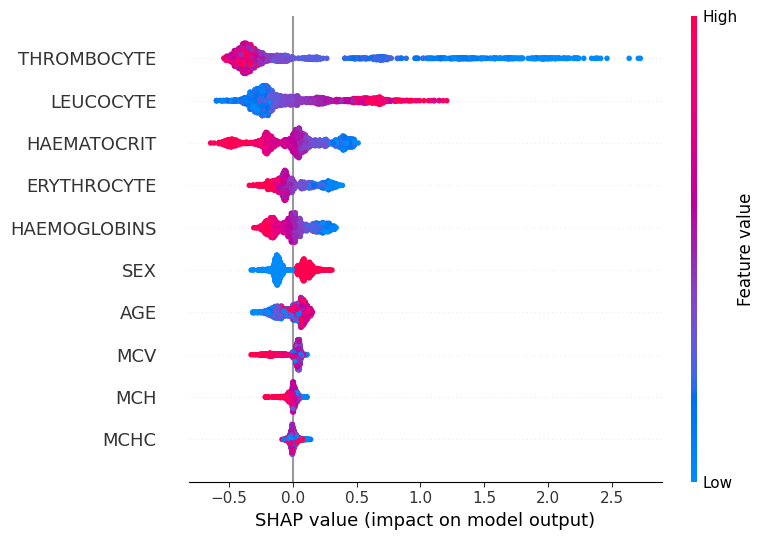

In [110]:
shap.initjs()
ex = shap.TreeExplainer(model)
print(f"Average treatment probability is {round(np.mean(y_test),4)}")
shap_values = ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test, max_display=30)

In [111]:
X_test

HAEMATOCRIT  HAEMOGLOBINS  ERYTHROCYTE  LEUCOCYTE  THROMBOCYTE   MCH  \
1077         44.0          15.2         5.75        3.8          155  26.4   
1248         37.6          12.3         4.44        7.3          387  27.7   
117          32.9          10.4         4.43        5.5          383  23.5   
4057         41.8          14.1         4.96        4.6          112  28.4   
2347         45.9          15.2         4.90       10.2          187  31.0   
...           ...           ...          ...        ...          ...   ...   
1610         40.4          13.6         4.53        7.1          288  30.0   
757          37.1          11.2         6.04        5.0          210  18.5   
1063         37.8          12.4         4.13        8.6          359  30.0   
3990         33.6          10.6         3.79        7.3          320  28.0   
84           34.4          11.7         4.34        5.8          213  27.0   

      MCHC   MCV  AGE  SEX  
1077  34.5  76.5   29    1  
1248  32.7  84.7   32    0  
117   31.6  74.3    4    1  
4057  33.7  84.3   76    0  
2347  33.1  93.7   50    1  
...    ...   ...  ...  ...  
1610  33.7  89.2   37    0  
757   30.2  61.4   24    1  
1063  32.8  91.5   29    0  
3990  31.5  88.7   75    0  
84    34.0  79.3    3    1  

[2206 rows x 10 columns]

In [112]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

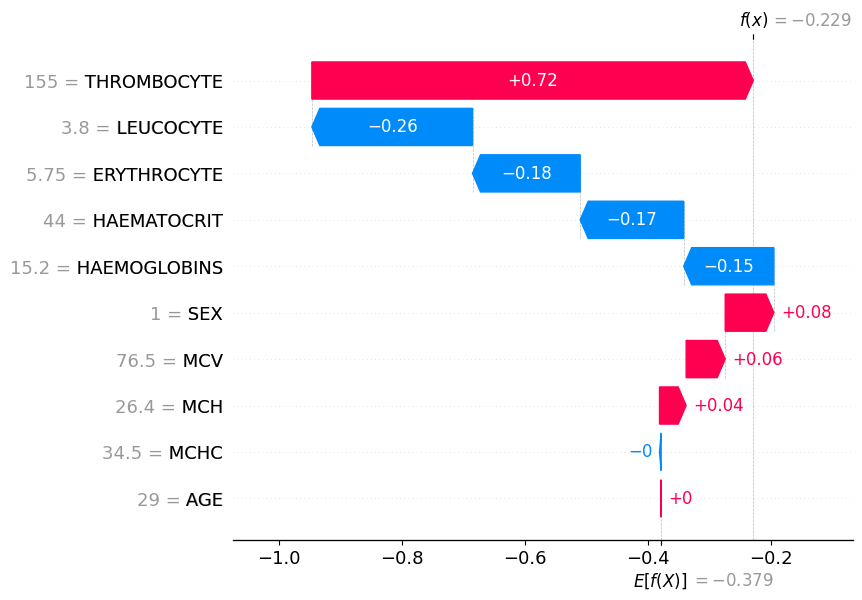

In [113]:
# Select an instance to explain
instance_index = 0  # You can change this index to any instance you want to explain
shap.plots.waterfall(shap_values[instance_index])

# Exploring incorrect predictions

In [75]:
import seaborn as sns

In [69]:
edf = df.loc[y_test.index].copy()
edf["PREDICTION"] = y_pred

In [73]:
edf["MATCH"] = edf["SOURCE"] == edf["PREDICTION"]

In [76]:
edf.head()

HAEMATOCRIT  HAEMOGLOBINS  ERYTHROCYTE  LEUCOCYTE  THROMBOCYTE   MCH  \
2717         26.6           8.6         3.21        7.0          221  26.8   
2320         41.2          13.1         4.68        4.9          299  28.0   
632          46.8          16.0         5.45        3.7          126  29.4   
2645         31.2          10.7         3.40        4.7          208  31.5   
1296         43.9          14.4         5.34        9.1          320  27.0   

      MCHC   MCV  AGE  SEX SOURCE PREDICTION  MATCH  
2717  32.3  82.9   56    1    out         in  False  
2320  31.8  88.0   49    0     in        out  False  
632   34.2  85.9   23    1    out        out   True  
2645  34.3  91.8   55    0     in        out  False  
1296  32.8  82.2   32    1    out        out   True

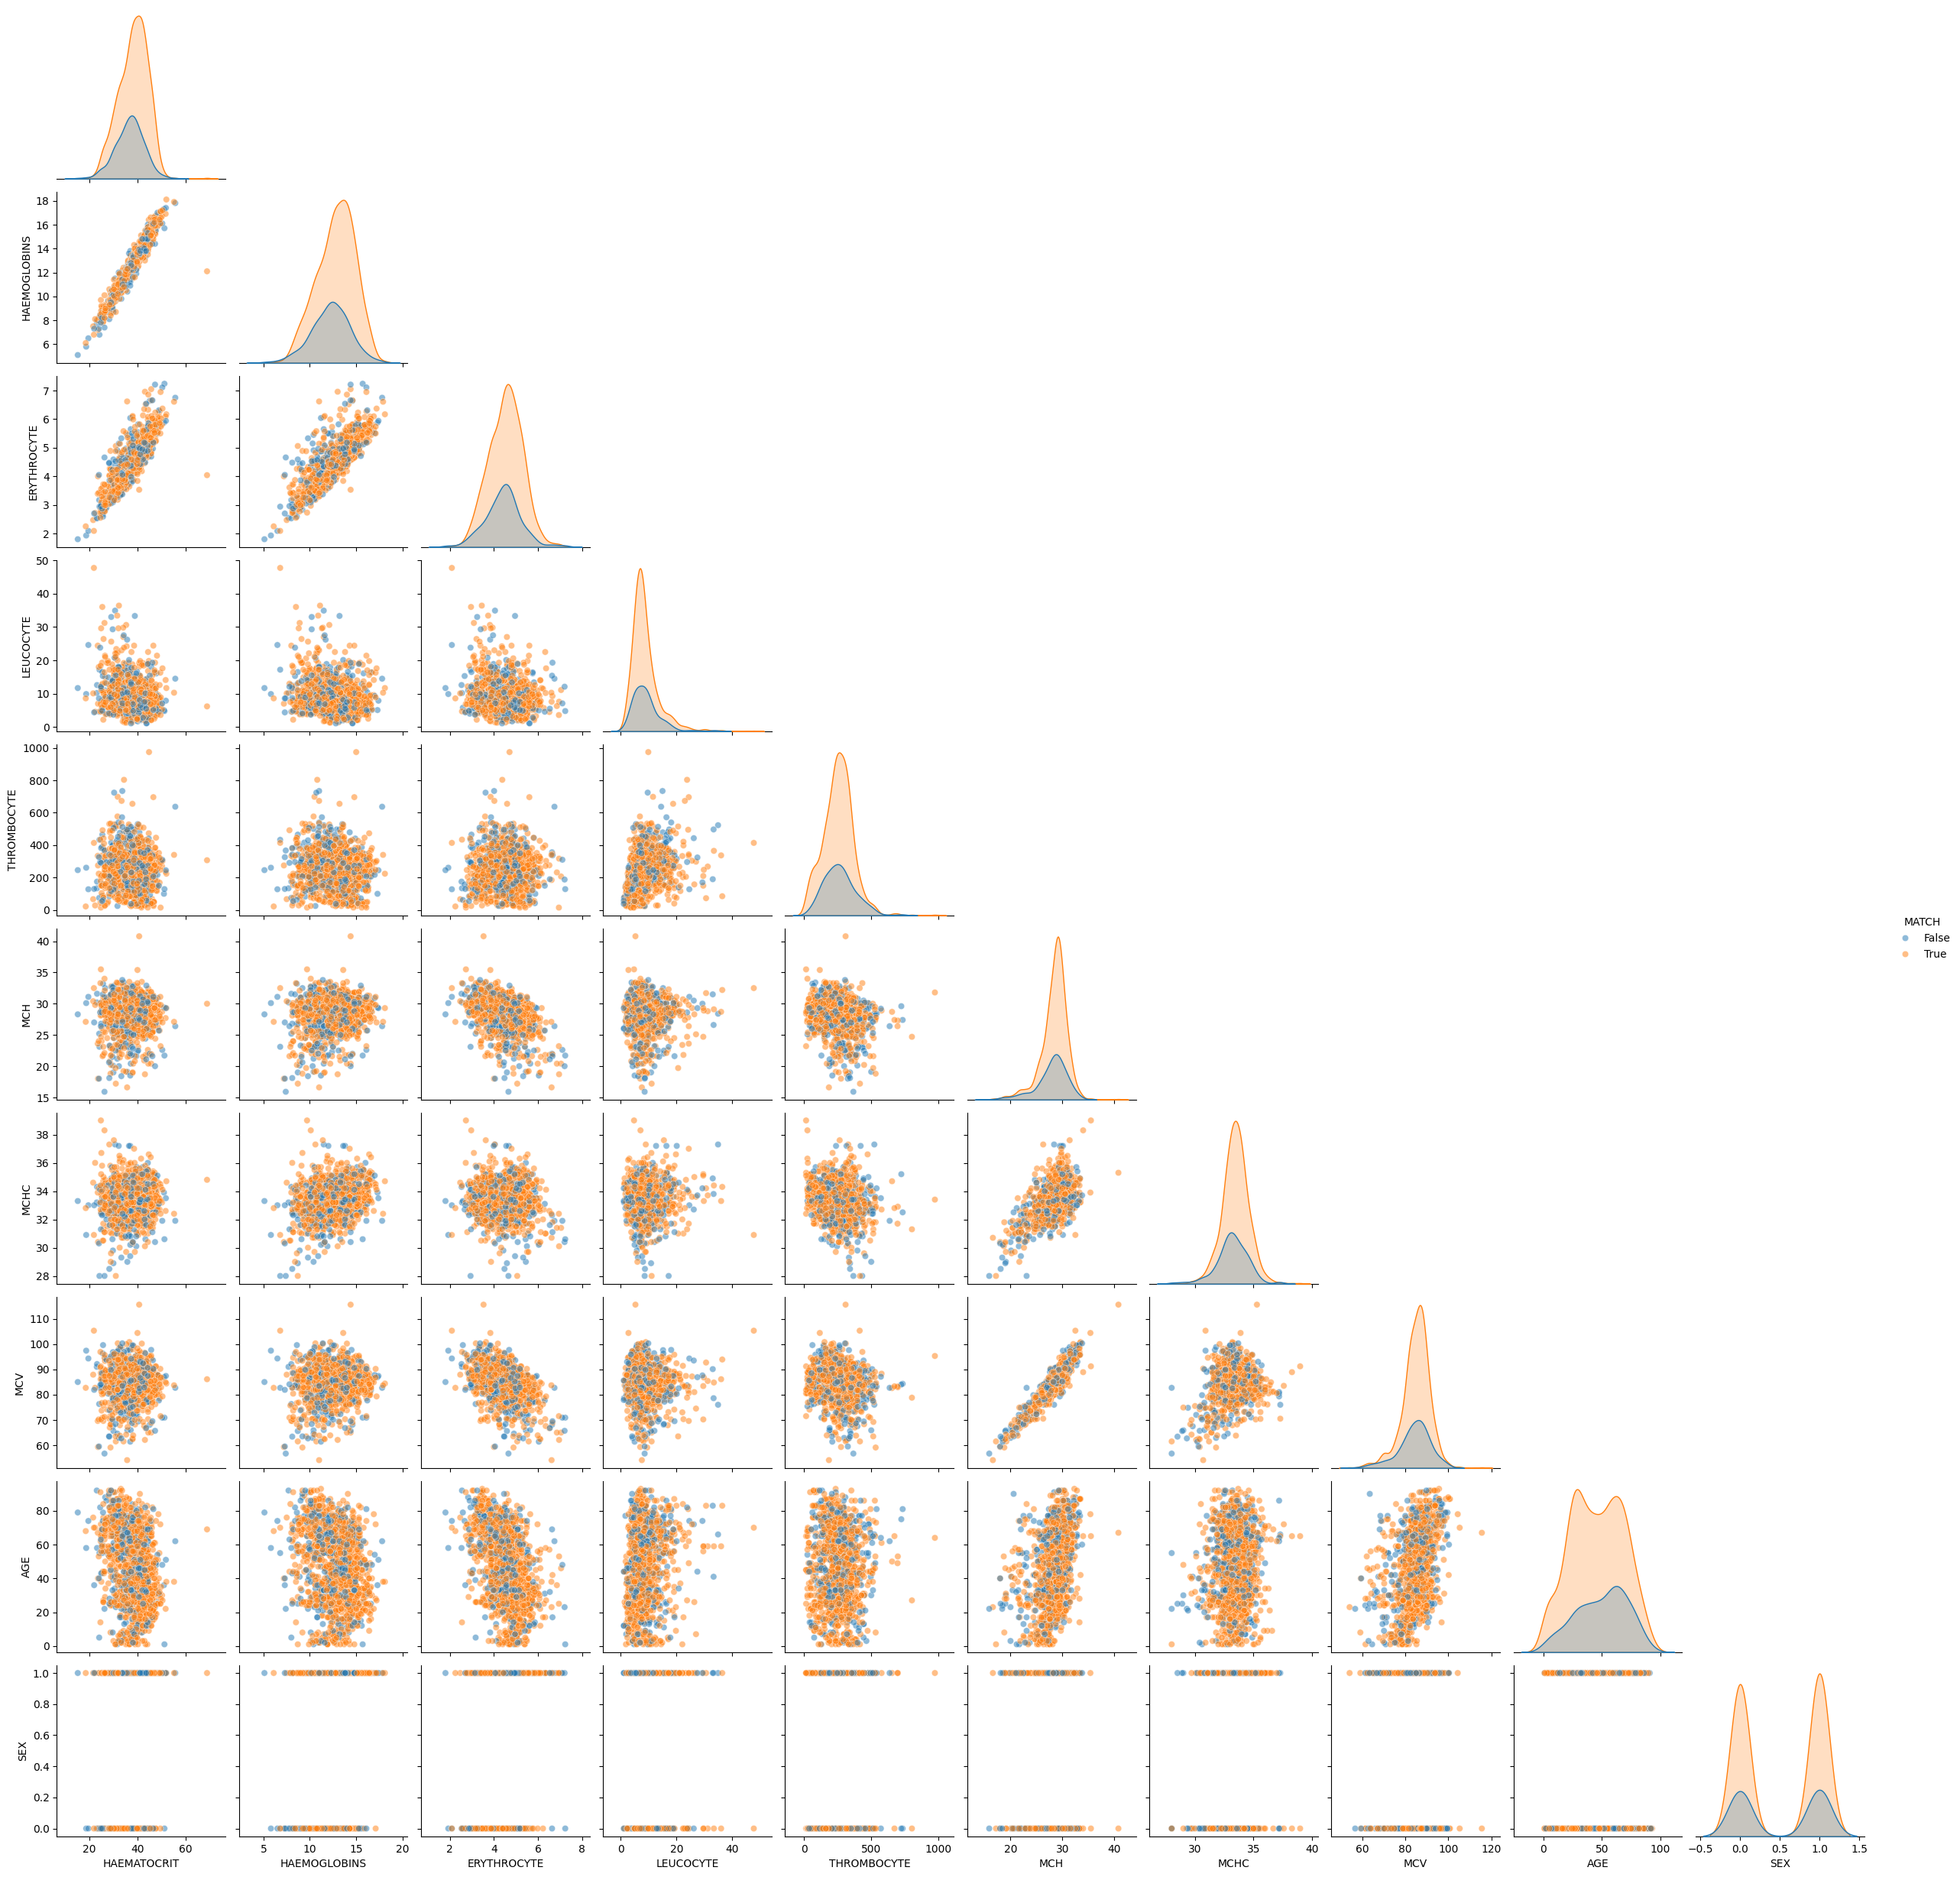

In [80]:
sns.pairplot(edf, diag_kind="kde", corner=True, hue="MATCH", plot_kws={"alpha": 0.5})

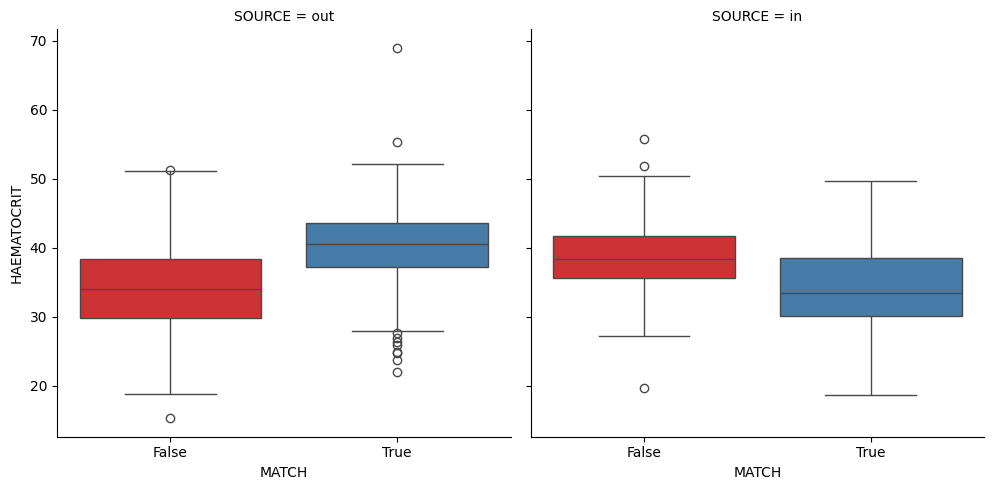

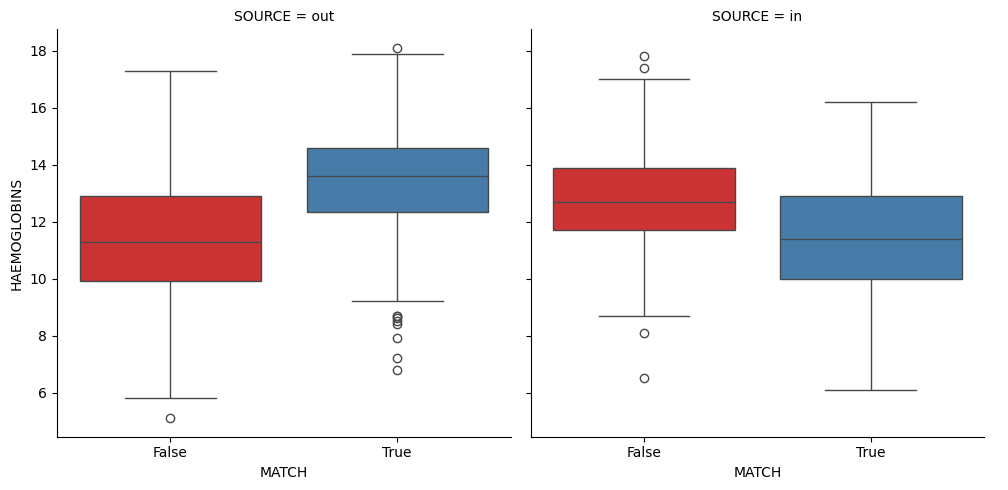

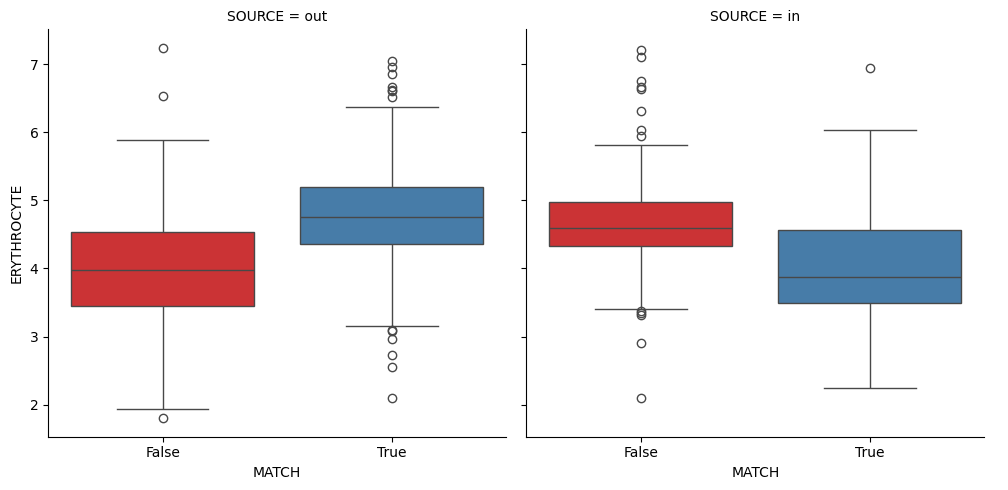

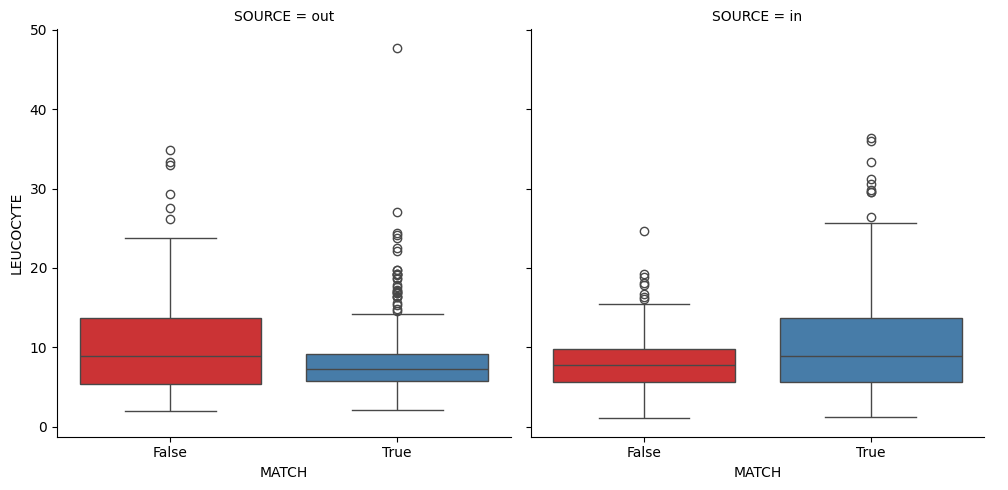

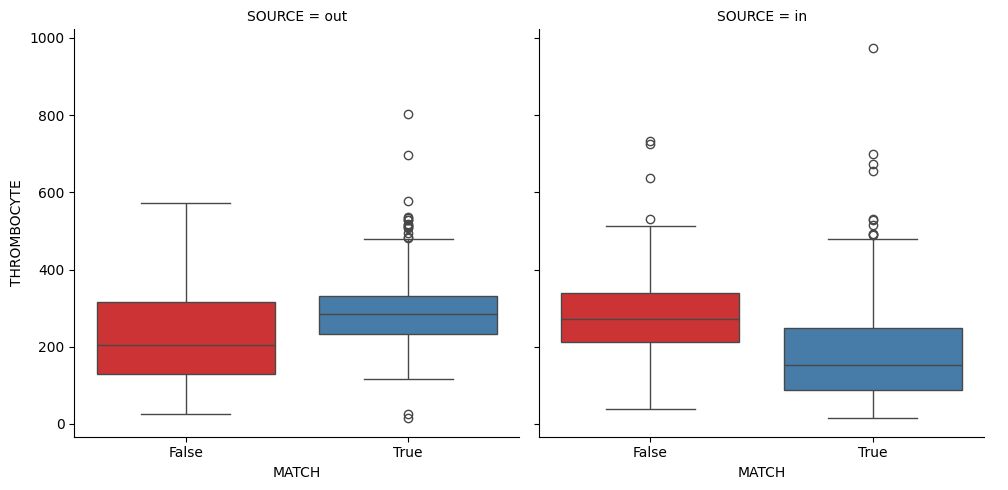

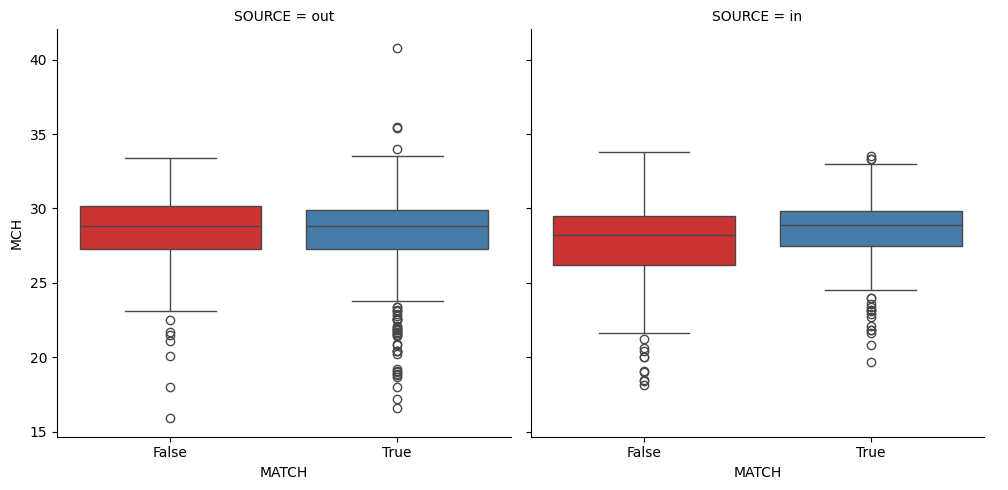

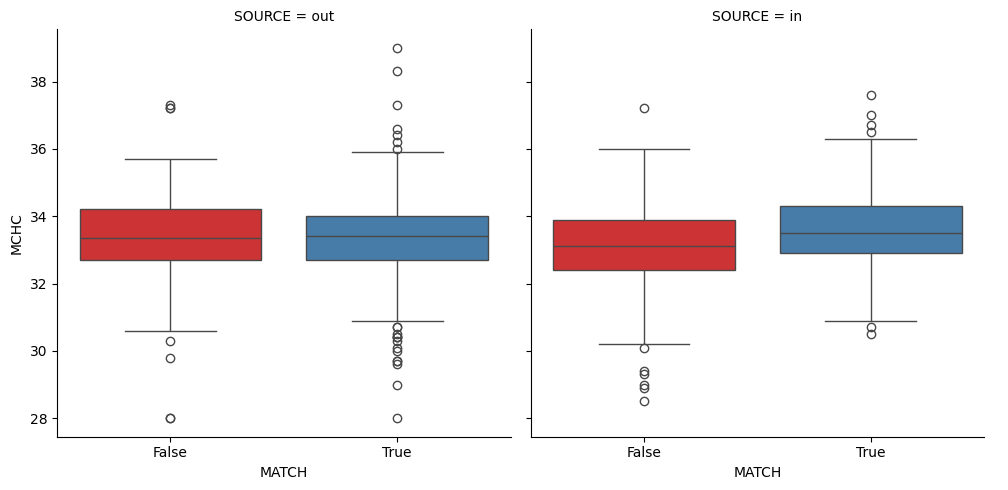

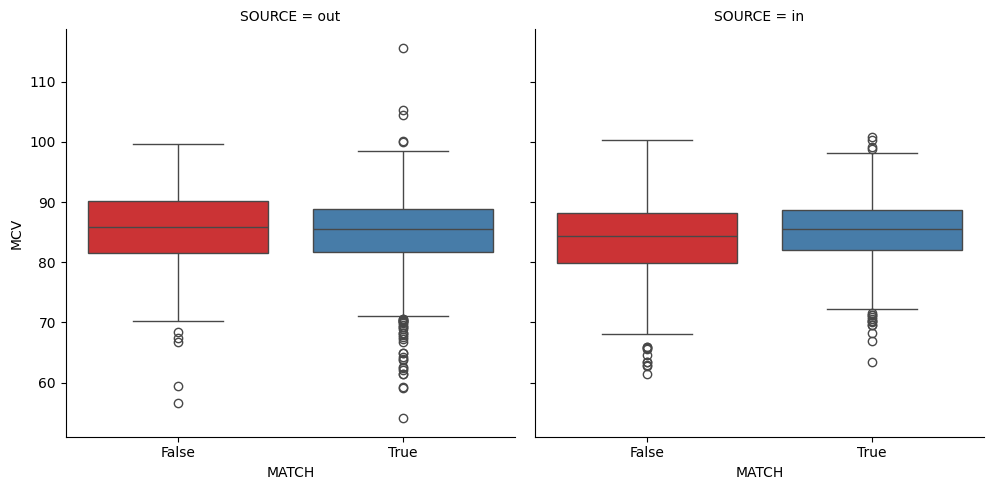

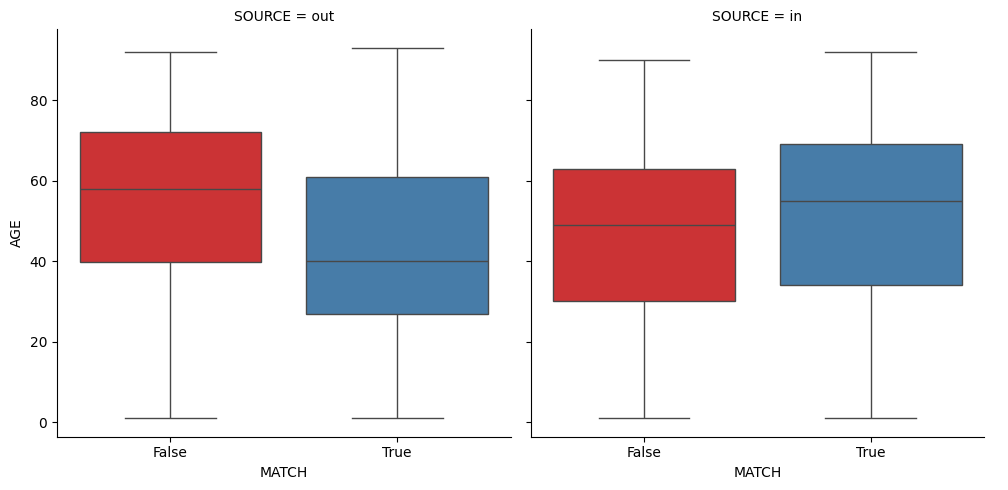

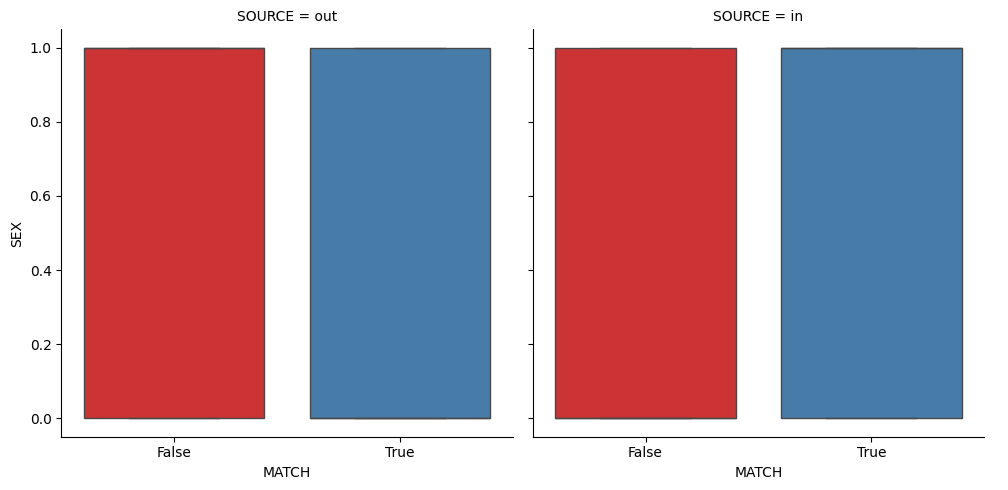

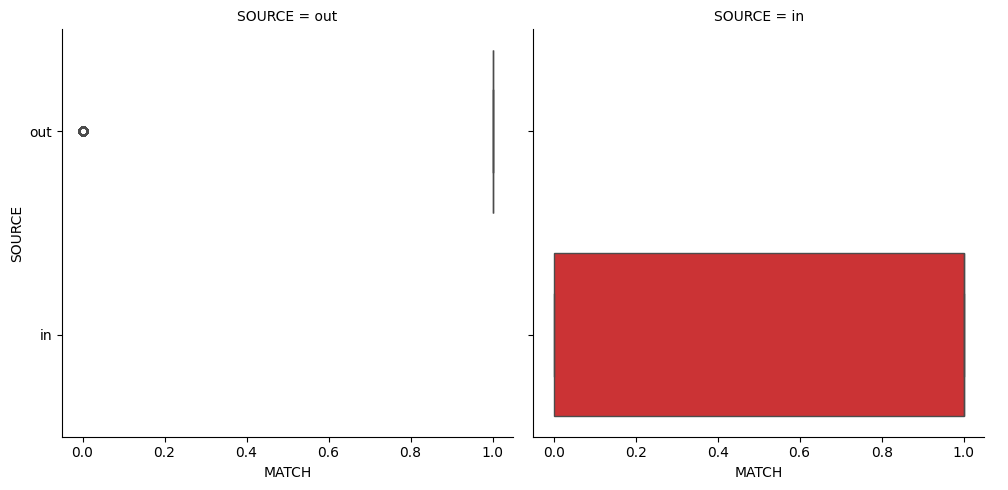

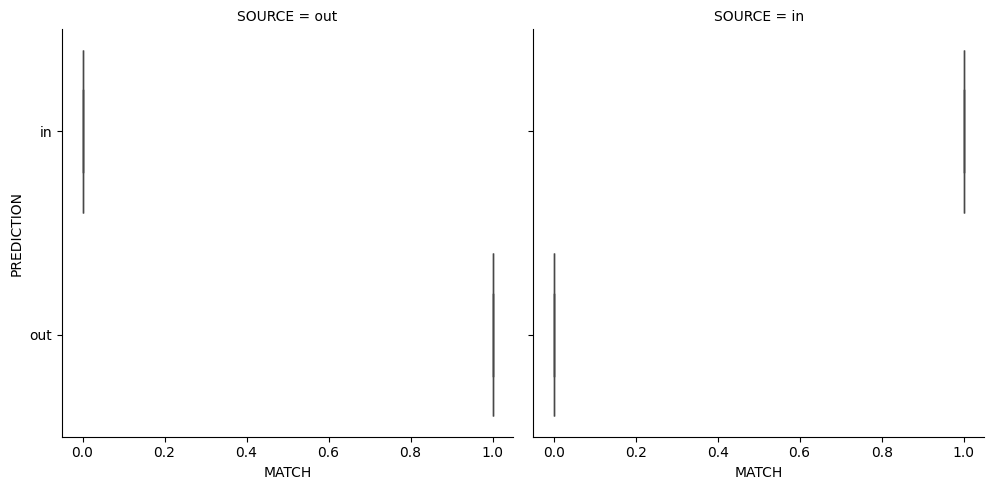

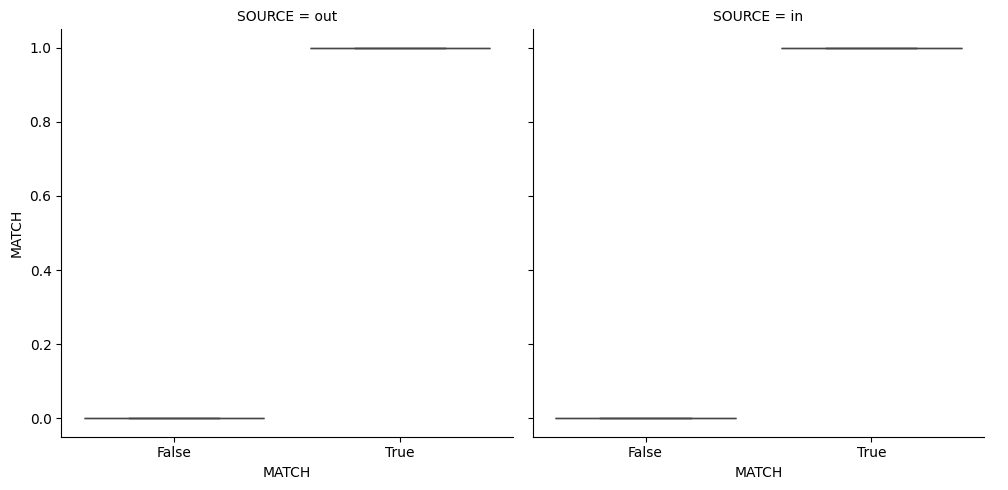

In [124]:
for c in edf.columns:
    g = sns.FacetGrid(edf, col="SOURCE", height=5, aspect=1)
    g.map(sns.boxplot, "MATCH", c, palette="Set1")
    g.add_legend()
    plt.show()

# Try to scale all the continuous variables

      HAEMATOCRIT  HAEMOGLOBINS  ERYTHROCYTE  LEUCOCYTE  THROMBOCYTE  \
2275     1.521571      0.918324     4.205082  -0.507635    -0.368181   
4093    -0.590225     -0.613524    -0.673427  -0.468456    -0.184678   
1727    -1.512041     -1.618799    -1.463160   0.099634     1.195966   
615      0.817639      0.870454     0.765924  -0.488046    -0.140986   
1610     0.348351      0.391752    -0.036546  -0.311742     0.260973   

           MCH      MCHC       MCV       AGE       SEX  
2275 -3.543672 -1.886871 -3.523787  0.113088 -1.043023  
4093  0.106741 -0.267275  0.263954  1.411455 -1.043023  
1727 -0.228501 -0.996093  0.191392 -0.350615 -1.043023  
615   0.032243  0.380563 -0.127881 -1.138910  0.958752  
1610  0.665478  0.299583  0.670302 -0.443356 -1.043023  

ROC AUC score for train 0.8346, and for test 0.7861


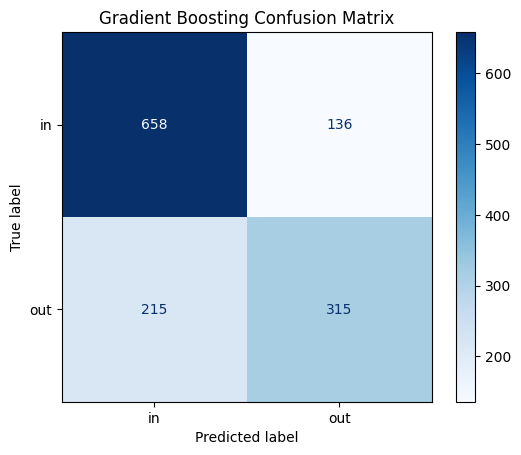

In [146]:
X_train, X_test, y_train, y_test = split_data(df)

print(X_train.head())

# initialize Pool
train_pool = Pool(X_train, y_train, cat_features=cat_cols_idx)
test_pool = Pool(X_test, y_test, cat_features=cat_cols_idx)

# specify the training parameters
model = CatBoostClassifier(
    iterations=1000,
    depth=5,
    border_count=23,
    l2_leaf_reg=0.3,
    learning_rate=3e-3,
    verbose=0,
)

# train the model
model.fit(train_pool)

# make the prediction using the resulting model
y_train_pred = model.predict_proba(train_pool)[:, 1]
y_test_pred = model.predict_proba(test_pool)[:, 1]

roc_auc_train = roc_auc_score(y_train, y_train_pred)
roc_auc_test = roc_auc_score(y_test, y_test_pred)

print()

print(
    f"ROC AUC score for train {round(roc_auc_train,4)}, and for test {round(roc_auc_test,4)}"
)

# Get the confusion matrix
cm = confusion_matrix(y_test, (y_test_pred > 0.5))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Plot the confusion matrix
# class_names = ["out", "in"]  # positive class should come the last
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["in", "out"])
disp.plot(cmap="Blues")
plt.title(k + " Confusion Matrix")
plt.show()

In [147]:
y_train_pred > 0.5

array([False, False,  True, ..., False, False, False])

In [150]:
acc = accuracy_score(y_train, (y_train_pred > 0.5).astype(int))
print("Accuracy : {:.2f}%".format(acc * 100))

f1 = f1_score(y_train, (y_train_pred > 0.5).astype(int))
print("F1 score : {:.5f}".format(f1))

Gradient Boosting Accuracy : 76.75%
Gradient Boosting F1 score : 0.67482


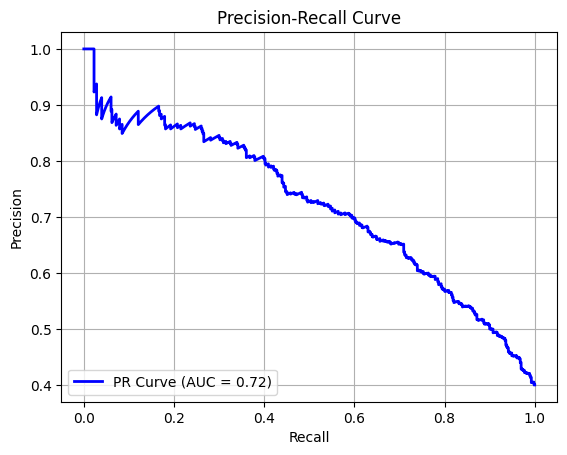

PR-AUC Score: 0.72
Average Precision Score: 0.72


In [139]:
# from sklearn.metrics import precision_recall_curve, auc, average_precision_score

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_test_pred)

# Compute PR-AUC
pr_auc = auc(recall, precision)
avg_precision = average_precision_score(y_test, y_test_pred)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color="blue", lw=2, label=f"PR Curve (AUC = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid()
plt.show()

print(f"PR-AUC Score: {pr_auc:.2f}")
print(f"Average Precision Score: {avg_precision:.2f}")

Average treatment probability is 0.4003


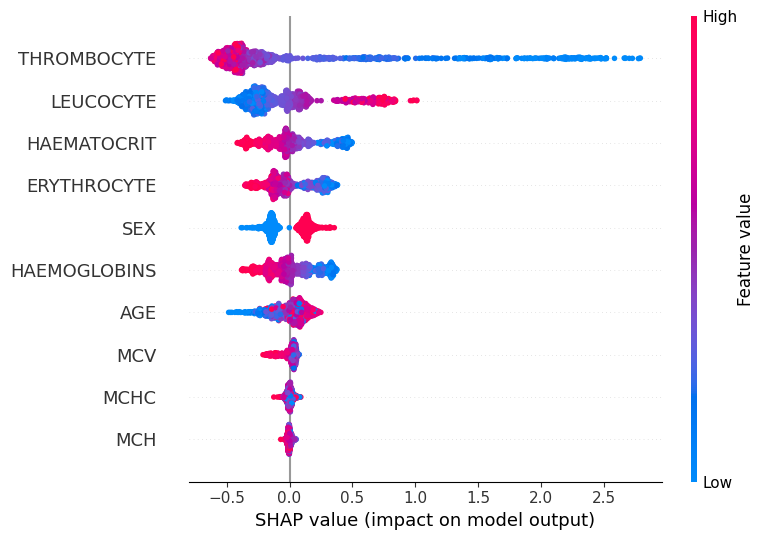

In [140]:
shap.initjs()
ex = shap.TreeExplainer(model)
print(f"Average treatment probability is {round(np.mean(y_test),4)}")
shap_values = ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test, max_display=30)

# Adjustments to features
Removing MCV, MCHC and MCH

      HAEMATOCRIT  HAEMOGLOBINS  ERYTHROCYTE  LEUCOCYTE  THROMBOCYTE  \
2275     1.521571      0.918324     4.205082  -0.507635    -0.368181   
4093    -0.590225     -0.613524    -0.673427  -0.468456    -0.184678   
1727    -1.512041     -1.618799    -1.463160   0.099634     1.195966   
615      0.817639      0.870454     0.765924  -0.488046    -0.140986   
1610     0.348351      0.391752    -0.036546  -0.311742     0.260973   

           AGE       SEX  
2275  0.113088 -1.043023  
4093  1.411455 -1.043023  
1727 -0.350615 -1.043023  
615  -1.138910  0.958752  
1610 -0.443356 -1.043023  

 Accuracy : 76.30%
 F1 score : 0.67086

ROC AUC score for train 0.8288, and for test 0.7835


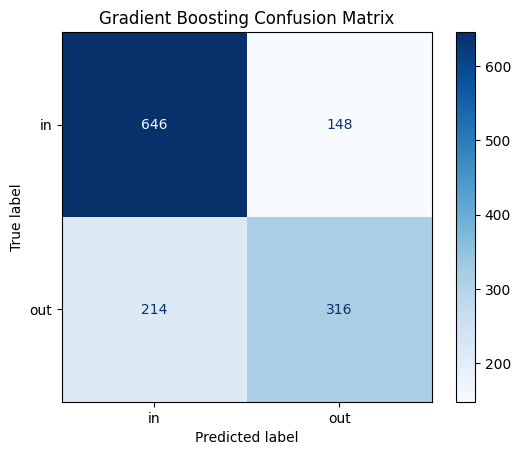

In [154]:
df = df.drop(columns=["MCV", "MCH", "MCHC"], errors="ignore")

X_train, X_test, y_train, y_test = split_data(df)

print(X_train.head())

# initialize Pool
train_pool = Pool(X_train, y_train, cat_features=cat_cols_idx)
test_pool = Pool(X_test, y_test, cat_features=cat_cols_idx)

# specify the training parameters
model = CatBoostClassifier(
    iterations=1000,
    depth=5,
    border_count=23,
    l2_leaf_reg=0.3,
    learning_rate=3e-3,
    verbose=0,
)

# train the model
model.fit(train_pool)

# make the prediction using the resulting model
y_train_pred = model.predict_proba(train_pool)[:, 1]
y_test_pred = model.predict_proba(test_pool)[:, 1]

roc_auc_train = roc_auc_score(y_train, y_train_pred)
roc_auc_test = roc_auc_score(y_test, y_test_pred)

print()

acc = accuracy_score(y_train, (y_train_pred > 0.5).astype(int))
print("Accuracy : {:.2f}%".format(acc * 100))

f1 = f1_score(y_train, (y_train_pred > 0.5).astype(int))
print("F1 score : {:.5f}".format(f1))

print()

print(
    f"ROC AUC score for train {round(roc_auc_train,4)}, and for test {round(roc_auc_test,4)}"
)

# Get the confusion matrix
cm = confusion_matrix(y_test, (y_test_pred > 0.5))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Plot the confusion matrix
# class_names = ["out", "in"]  # positive class should come the last
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["in", "out"])
disp.plot(cmap="Blues")
plt.title(k + " Confusion Matrix")
plt.show()

# XGBoost

ROC AUC score for train 0.928, and for test 0.7945

Accuracy : 85.04%
F1 score : 0.79630



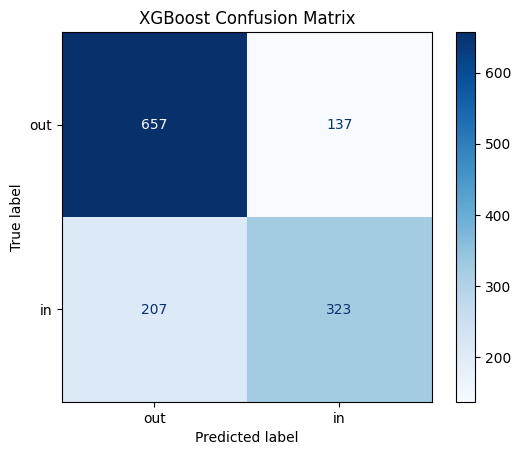

In [ ]:
import xgboost as xgb

model_name = "XGBoost"

df = pd.read_csv("../data/data-ori.csv")

main_label = "SOURCE"

df["SEX"] = df["SEX"].replace({"F": 0, "M": 1})

# Convert the dataset into DMatrix, which is a data structure that XGBoost uses
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set the parameters for the XGBoost model
params = {
    "objective": "binary:logistic",
    "max_depth": 5,
    "eta": 0.1,
    "eval_metric": "auc",
}

# Train the model
num_rounds = 100
bst = xgb.train(params, dtrain, num_rounds)

# Make predictions
y_train_pred = bst.predict(dtrain)
y_test_pred = bst.predict(dtest)

# Evaluate the model
roc_auc_train = roc_auc_score(y_train, y_train_pred)
roc_auc_test = roc_auc_score(y_test, y_test_pred)

print(
    f"ROC AUC score for train {round(roc_auc_train, 4)}, and for test {round(roc_auc_test, 4)}"
)

print()

acc = accuracy_score(y_train, (y_train_pred > 0.5).astype(int))
print("Accuracy : {:.2f}%".format(acc * 100))

f1 = f1_score(y_train, (y_train_pred > 0.5).astype(int))
print("F1 score : {:.5f}".format(f1))

print()

# Get the confusion matrix
cm = confusion_matrix(y_test, (y_test_pred > 0.5).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["out", "in"])
disp.plot(cmap="Blues")
plt.title("XGBoost Confusion Matrix")
plt.show()

logging.info(
    f"""
    Model: {model_name},
    Parameters: {params},
    Number of Rounds: {num_rounds},
    Accuracy: {acc},
    F1 Score: {f1},
    ROC AUC: {roc_auc_test},
    Confusion Matrix: {cm},
    Features: {list(X_train.columns)}
    """
)


Accuracy : 85.04%
F1 score : 0.79630
